## Final Project Submission

Please fill out:
* Student name: Jaklyn Soler
* Student pace: Full Time
* Scheduled project review date/time: 
* Instructor name: Rafael Carrasco
* Blog post URL:

# Strategic Approach

The stakeholder, SyriaTel, is a telecommunications company whose goal is to better understand what factors are causing customer churn. Due to limits on data size, the model will only be robust enough to be used by SyriaTel to analyze their specific data provided.

By exploring typical customer churn and using the CRISP-DM framework, I will seek to answer the following questions: 

1. What features of the dataset are primary determinants of customer churn and to what extent?

2. What are the ways that these findings can be interpreted and how can SyriaTel implement cost-effective solutions?

3. Will these solutions be feasible in reducing the customer churn rate by at least 7%?

# Question One

# What features of the dataset are primary determinants of customer churn and to what extent?

# Import Data and Relevant Packages

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import itertools
from imblearn.over_sampling import SMOTE, ADASYN
import imblearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import Pipeline
from scipy.stats import randint
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, auc, confusion_matrix, classification_report, recall_score
from sklearn.neighbors import KNeighborsClassifier
import pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.datasets import make_blobs, make_moons
from sklearn.svm import SVC
from numpy import loadtxt

In [2]:
one_hot_df = pd.read_pickle("./one_hot_df.pkl")

# Models Explored:
### - Logistic Regression
### - K-Nearest Neighbors 
### - Decision Tree Classifier
### - Gradient Boost
### - Random Forest
### - XGBoost

# Optimising for Recall, XGBoost with GridSearchCV Performed the Best

### Train Test Split

In [3]:
X = one_hot_df.drop(columns='churn')
y = one_hot_df.churn

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
print('Training Set: ')
print(y_train.value_counts())
print('Normalized:')
print(y_train.value_counts(normalize=True))
print('\n')
# Test set
print('Test Set')
print(y_test.value_counts())
print('Normalized:')
print(y_test.value_counts(normalize=True))

Training Set: 
0.0    2284
1.0     382
Name: churn, dtype: int64
Normalized:
0.0    0.856714
1.0    0.143286
Name: churn, dtype: float64


Test Set
0.0    566
1.0    101
Name: churn, dtype: int64
Normalized:
0.0    0.848576
1.0    0.151424
Name: churn, dtype: float64


# Initial XGBoost Model

In [6]:
xg = XGBClassifier(random_state = 1)

xg.fit(X_train, y_train)

training_preds = xg.predict(X_train)
test_preds = xg.predict(X_test)

training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)
train_recall = recall_score(y_train, training_preds)
test_recall = recall_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))
print('Training Recall: {:.4}%'.format(train_recall * 100))
print('Test Recall: {:.4}%'.format(test_recall * 100))

Training Accuracy: 97.0%
Validation accuracy: 94.9%
Training Recall: 79.84%
Test Recall: 71.29%


# Follow-Up Model with GridSearchCV

In [7]:
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

In [8]:
grid_xg = GridSearchCV(xg, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_xg.fit(X_train, y_train)

best_parameters = grid_xg.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_xg.predict(X_train)
test_preds = grid_xg.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)
train_recall = recall_score(y_train, training_preds)
test_recall = recall_score(y_test, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))
print('Training Recall: {:.4}%'.format(train_recall * 100))
print('Test Recall: {:.4}%'.format(test_recall * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 6
min_child_weight: 1
n_estimators: 100
subsample: 0.7

Training Accuracy: 98.72%
Validation accuracy: 95.35%
Training Recall: 91.1%
Test Recall: 74.26%


# Feature Importance

Importance of features was pulled from the initial model as it could not easily be fulled from the GridSearchCV model.

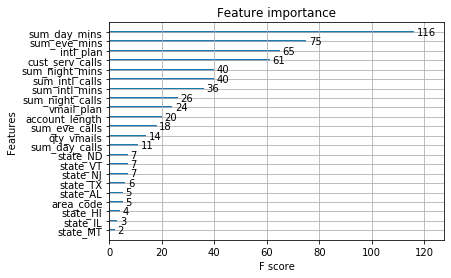

In [9]:
plot_importance(xg)
plt.show()

### Important Features in Terms of Gain: 
 - sum_day_mins
 - sum_eve_mins
 - intl_plan
 - cust_serv_calls
 - sum_night_mins
 - sum_intl_calls
 - sum_intl_mins
 - sum_night_calls
 - vmail_plan
 - account_length
 - sum_eve_calls
 - qty_vmails
 - sum_day_calls
 - state_ND
 - state_VT
 - state_NJ
 - state_TX
 - state_AL
 - area_code
 - state_HI
 - state_IL
 - state_MT

# Tuning with Only top 12 Important Features

In [10]:
one_hot_df.head()

,account_length,area_code,intl_plan,vmail_plan,qty_vmails,sum_day_mins,sum_day_calls,total_day_charge,sum_eve_mins,sum_eve_calls,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,128,415,0,1,25,265.1,110,45.07,197.4,99,...,0,0,0,0,0,0,0,0,0,0
1,107,415,0,1,26,161.6,123,27.47,195.5,103,...,0,0,0,0,0,0,0,0,0,0
2,137,415,0,0,0,243.4,114,41.38,121.2,110,...,0,0,0,0,0,0,0,0,0,0
3,84,408,1,0,0,299.4,71,50.90,61.9,88,...,0,0,0,0,0,0,0,0,0,0
4,75,415,1,0,0,166.7,113,28.34,148.3,122,...,0,0,0,0,0,0,0,0,0,0


In [11]:
im_df = one_hot_df[['sum_day_mins', 'sum_eve_mins', 'intl_plan', 'cust_serv_calls', 'sum_night_mins', 'sum_intl_calls', 'sum_intl_mins', 'sum_night_calls', 'vmail_plan', 'account_length', 'sum_eve_calls', 'qty_vmails', 'sum_day_calls', 'churn']]

In [12]:
im_df.head()

,sum_day_mins,sum_eve_mins,intl_plan,cust_serv_calls,sum_night_mins,sum_intl_calls,sum_intl_mins,sum_night_calls,vmail_plan,account_length,sum_eve_calls,qty_vmails,sum_day_calls,churn
0,265.1,197.4,0,1,244.7,3,10.0,91,1,128,99,25,110,0.0
1,161.6,195.5,0,1,254.4,3,13.7,103,1,107,103,26,123,0.0
2,243.4,121.2,0,0,162.6,5,12.2,104,0,137,110,0,114,0.0
3,299.4,61.9,1,2,196.9,7,6.6,89,0,84,88,0,71,0.0
4,166.7,148.3,1,3,186.9,3,10.1,121,0,75,122,0,113,0.0


In [13]:
X = im_df.drop(columns = 'churn')
y = im_df.churn

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost with Top Feature Selection

In [15]:
xg = XGBClassifier(random_state = 1)

xg.fit(X_train, y_train)

training_preds = xg.predict(X_train)
test_preds = xg.predict(X_test)

training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)
train_recall = recall_score(y_train, training_preds)
test_recall = recall_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))
print('Training Recall: {:.4}%'.format(train_recall * 100))
print('Test Recall: {:.4}%'.format(test_recall * 100))

Training Accuracy: 96.96%
Validation accuracy: 95.05%
Training Recall: 79.58%
Test Recall: 73.27%


# XGBoost with Top Feature Selection and GridSearchCV

In [16]:
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

In [17]:
grid_xg = GridSearchCV(xg, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_xg.fit(X_train, y_train)

best_parameters = grid_xg.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_xg.predict(X_train)
test_preds = grid_xg.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)
train_recall = recall_score(y_train, training_preds)
test_recall = recall_score(y_test, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))
print('Training Recall: {:.4}%'.format(train_recall * 100))
print('Test Recall: {:.4}%'.format(test_recall * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 6
min_child_weight: 1
n_estimators: 100
subsample: 0.7

Training Accuracy: 98.76%
Validation accuracy: 95.65%
Training Recall: 91.36%
Test Recall: 76.24%


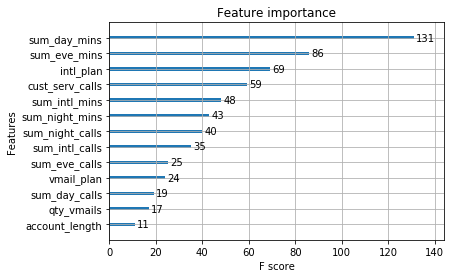

In [19]:
plot_importance(xg)
plt.show()

# Computing Importance with SHAP (SHapley Additive exPlanations) Values

In [22]:
import shap

In [23]:
X_display,y_display = shap.datasets.nhanesi(display=True)

In [24]:
explainer = shap.TreeExplainer(xg)
shap_values = explainer.shap_values(X_test)

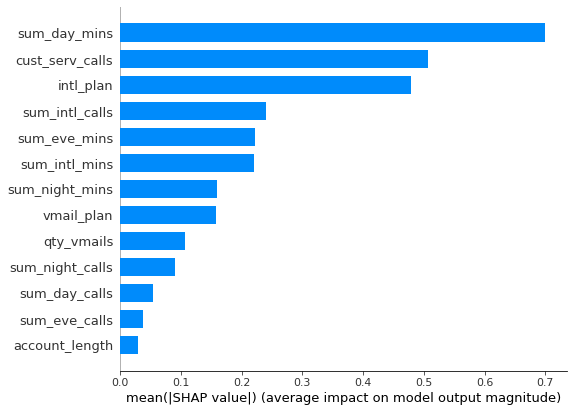

In [25]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

### Initiating Javascript

In [26]:
shap.initjs()

### Features Contributing to Pushing Model Output

The graph below shows features each contributing to push the model output from the base value to the model output. Features pushing the prediction higher are shown in red. Those pushing the prediction lower are in blue. 

In [27]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [28]:
X.shape

(3333, 13)

In [29]:
shap_interaction_values = shap.TreeExplainer(xg).shap_interaction_values(X)

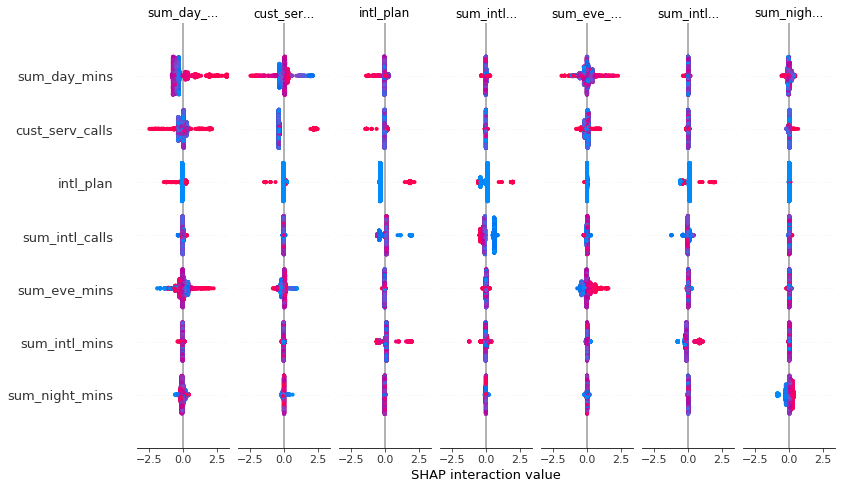

In [30]:
shap.summary_plot(shap_interaction_values, X)


# Observing Features by SHAP Values

### Contributors of High Customer Churn: Value of One

- High total number of day minutes
- High number of customer service calls
- Customers who have an international plan
- High number of night minutes
- High number of international minutes

### Contributors of Low Customer Churn: Value of Zero

- Customers with a voicemail plan
- Customers with higher number of voicemails
- High number of international calls

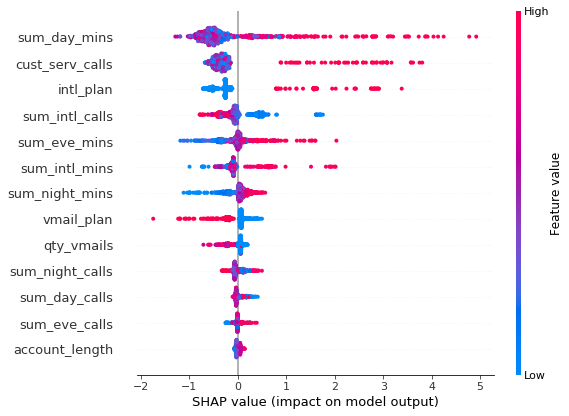

In [31]:
shap.summary_plot(shap_values, X_test)

# Investigating Findings

### High Churn Questions to Ask SyriaTel + Potential Solutions

#### High Total Number of Day Minutes
 - Why would a high total number of day minutes contribute to high customer churn? If this is due to higher rates, SyriaTel should consider offering a plan with a constant monthly fee and investigating their compeitition in the market. Furthermore, a strategic marketing plan could specifically leverage SyriaTel above the competition.
 
#### High Number of Customer Service Calls 
 - Does a high number of customer service calls indicate multiple problems? If so, can SyriaTel use each opportunity to shift the customer experience from a negative one into a positive one? How can the company as a whole improve its methods of problem solving to ensure that a customer is not calling about the same problem more than one time?
 
#### Customers with an International Plan
 - Why would customers with an international plan be more likely to churn? Is this a result of people leaving the country? If so, how can SyriaTel have a more competitive international plan? Can they increase flexibility by 'pausing' a plan and being able to 'turn the plan back on' whenever the customer returns to the country? If the churn is due to high fees, can SyriaTel create a flat-fee plan for the international plan? 
 
#### High Number of Night Minutes and International Minutes
 - Why is a high number of night minutes and international minutes contributing to customer churn? Is the high number of night minutes driving up the price of the phone bill?
 
 
### Low Churn Questions to Ask SyriaTel + Potential Solutions
 
#### Customers with a Voicemail Plan
 - Why are customers with a voicemail plan less likely to leave SyriaTel? Is this because they are providing people with their phone number? Is there a contract associated with it? 

#### High Number of Voicemails
 - Why are customers with a high number of voicemails less likely to leave SyriaTel? Is is due to the inconvenience of changing their phone number?

#### High Number of International Calls 
 - Customers with a high number of international calls are less likely to churn, but customers with an international plan and a high number of international minutes are more likely to churn. Is this due to the calls of these customers being higher in quantity but shorter in length, thus resulting in a lower customer charge?
 
 

# Conclusion

It seems that SyriaTel could be losing customers due to rates that fluctuate from month to month. If this is the case, a flat monthly fee with a contract would be a better business model for acquiring customers.

### Additional Recommendations: 
- Initiating customer feedback surveys for customer service calls.
- Initiating customer feedback surveys for customers leaving. This could be a requirement of cancellation via online survey or in person. 

# Future Work
It would be nice to know the price of the plans and the averages for customers churning to better understand the pain points of SyriaTel customers. Further research could provide information on the time frames and marketing strategies that SyriaTel uses. 